In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Inputs import sched_out_trajectories
from datetime import timedelta

In [4]:
# THIS IS HOW TO SHRINK GTFS STOP TIMES
routes_interest= [20]
gtfs_stop_t_df = pd.read_csv('in/raw/gtfs/stop_times.txt') # THIS SHOULD BE THE HEAVY ONE
gtfs_trips_df = pd.read_csv('in/raw/gtfs/trips.txt')
gtfs_trips_df = gtfs_trips_df[gtfs_trips_df['route_id'].isin(routes_interest)]
focus_trip_ids = gtfs_trips_df['trip_id'].unique()
gtfs_stop_t_df = gtfs_stop_t_df[gtfs_stop_t_df['trip_id'].isin(focus_trip_ids)]
gtfs_stop_t_df.to_csv('in/raw/gtfs/stop_times2.txt', index=False)

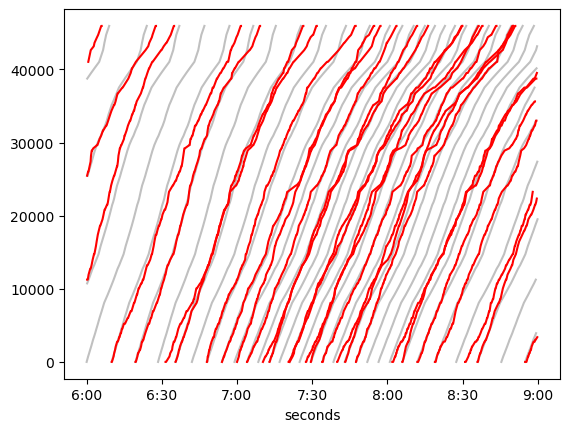

In [45]:
# THIS IS HOW TO CREATE TRAJECTORY PLOTS
df_out = pd.read_pickle('out/NC_Terminal/0621-144310-trip_record_outbound.pkl')
df_out.columns
df_arr_t = df_out[['trip_id', 'replication', 'dist_traveled', 'arr_sec']].copy()
df_arr_t = df_arr_t.rename(columns={'arr_sec': 'seconds'})
df_dep_t = df_out[['trip_id', 'replication', 'dist_traveled', 'dep_sec']].copy()
df_dep_t = df_dep_t.rename(columns={'dep_sec': 'seconds'})
df_sched_t = df_out[['trip_id', 'replication', 'dist_traveled', 'schd_sec']].copy()
df_times = pd.concat([df_arr_t, df_dep_t], axis=0, ignore_index=True)
df_times = df_times.sort_values(by=['trip_id', 'seconds'])
df_sched_t = df_sched_t.sort_values(by=['trip_id', 'schd_sec'])
replication = 1
time_period = (6*60*60, 9*60*60)
df_times_rep = df_times[df_times['replication'] == replication].copy()
df_times_rep = df_times_rep[(df_times_rep['seconds'] >= time_period[0]) & (df_times_rep['seconds'] <= time_period[1])]
df_times_rep = df_times_rep.set_index('seconds')
df_sched_t_rep = pd.DataFrame(sched_out_trajectories, columns=['trip_id', 'schd_sec', 'dist_traveled'])
df_sched_t_rep = df_sched_t_rep[(df_sched_t_rep['schd_sec'] >= time_period[0]) & (df_sched_t_rep['schd_sec'] <= time_period[1])]
df_sched_t_rep = df_sched_t_rep.set_index('schd_sec')
df_sched_t_rep.groupby('trip_id')['dist_traveled'].plot(color='silver')
df_times_rep.groupby('trip_id')['dist_traveled'].plot(color='red')
x_ticks = [x for x in range(time_period[0], time_period[1]+30*60, 30*60)]
x_labels = [str(timedelta(seconds=round(x)))[:-3] for x in x_ticks]
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.show()

In [1]:
from Inputs import trips_df